In [315]:
%matplotlib inline

Mixture of Gaussians example
------------

The idea is to show with an example how the mixture of gaussians methodology works. The codes are mainly adapted from [here](http://scikit-learn.org/stable/modules/mixture.html) and links therein.

Import the modules we will need:

In [316]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn import mixture
from sklearn.model_selection import StratifiedKFold
import itertools
from matplotlib.colors import LogNorm

Gaussian function:

In [317]:
def gauss_function(x, amp, x0, sigma):
    return amp * np.exp(-(x - x0) ** 2. / (2. * sigma ** 2.))

Generate the data. let's imagine we have two neuron whose activity depends on the state of the network:

In [318]:
num_samples_per_st = 2000#2000
distance_between_means = 1 
neurons_corr = 0.
# Activity of the two neurons under network state 1:
mean = (distance_between_means, distance_between_means)
cov = [[1, -neurons_corr], [-neurons_corr, 1]]
st1 = np.random.multivariate_normal(mean, cov, num_samples_per_st).T
print('Shape of st1')
print(st1.shape)
# Activity of the two neurons under network state 1:
mean = (-distance_between_means, -distance_between_means)
cov = [[1, neurons_corr], [neurons_corr, 1]]
st2 = np.random.multivariate_normal(mean, cov, num_samples_per_st).T
print('Shape of st2')
print(st2.shape)
# Raw activity:
raw_activity = np.concatenate((st1,st2),axis=1)
print('Raw data shape')
print(raw_activity.shape)

#ground truth states
gt_sts = np.concatenate((np.zeros((num_samples_per_st,1)),np.ones((num_samples_per_st,1)))).reshape((2*num_samples_per_st,))

Shape of st1
(2, 2000)
Shape of st2
(2, 2000)
Raw data shape
(2, 4000)


Plot the data:

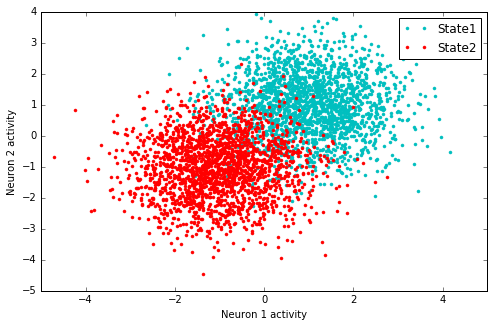

In [319]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8, 5])
ax.plot(raw_activity[0,gt_sts==0],raw_activity[1,gt_sts==0],'.c',label='State1')
ax.plot(raw_activity[0,gt_sts==1],raw_activity[1,gt_sts==1],'.r',label='State2')
ax.set_xlabel('Neuron 1 activity')
ax.set_ylabel('Neuron 2 activity')
ax.legend()

Separate data into train and test sets:

In [320]:
# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=5)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(raw_activity.T,gt_sts)))
X_train = raw_activity[:,train_index]
y_train = gt_sts[train_index]
X_test = raw_activity[:,test_index]
y_test = gt_sts[test_index]

n_classes = len(np.unique(y_train))


Now we fit the data:

In [321]:
# Fit GMM
gmm = GaussianMixture(n_components=2, covariance_type="full", tol=0.001)
gmm = gmm.fit(X=X_train.T)


and plot:

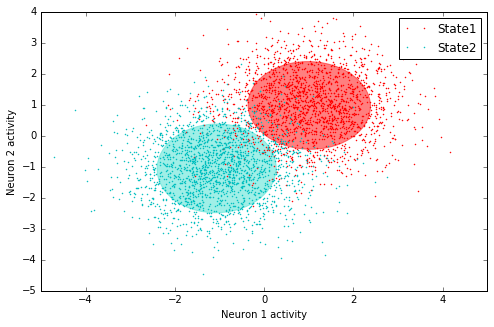

In [322]:
#function to plot ellipses
colors = ['red', 'turquoise','green','blue','black','yellow']
def make_ellipses(gmm, ax):
    for n in range(gmm.n_components):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        #np.linalg.eigh return the eigenvalues and eigenvectors of a Hermitian or symmetric matrix.
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])#this normalize the first eigen vector (probably not necessary)
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=colors[n])
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8, 5])
ax.plot(raw_activity[0,gt_sts==0],raw_activity[1,gt_sts==0],'.r',label='State1',markerSize=2)
ax.plot(raw_activity[0,gt_sts==1],raw_activity[1,gt_sts==1],'.c',label='State2',markerSize=2)
ax.set_xlabel('Neuron 1 activity')
ax.set_ylabel('Neuron 2 activity')
ax.legend()
make_ellipses(gmm,ax)

Model selection. We will test different assumtptions for the covariances matrices. More in details, we compare the mixture of Gaussians fir with spherical, diagonal, full, and tied:

- 'full' (each component has its own general covariance matrix),
- 'tied' (all components share the same general covariance matrix),
- 'diag' (each component has its own diagonal covariance matrix),
- 'spherical' (each component has its own single variance).

Although one would expect full covariance to perform best in general, it is **prone to overfitting on small datasets and does not generalize well to held out test data**.


In [323]:
lowest_bic = np.infty
highest_bic = -np.infty
bic = []
n_components_range = range(1, 7)#number of components from 1 to 6
cv_types = ['spherical', 'tied', 'diag', 'full']#types of covariances
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with the Expectation-Maximization algorithm
        #Define the model
        gmm_temp = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        #fit the data
        gmm_temp.fit(X_train.T)
        #With this line we obtain the BIC score
        bic.append(gmm_temp.bic(X_train.T))
        #if the performance is better in terms of BIC we keep the model as the best so far
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm_temp
        #if the performance is better in terms of BIC we keep the model as the best so far
        if bic[-1] >= highest_bic:
            highest_bic = bic[-1]
            worst_gmm = gmm_temp

bic = np.array(bic)


Plot BIC score for all considered models:

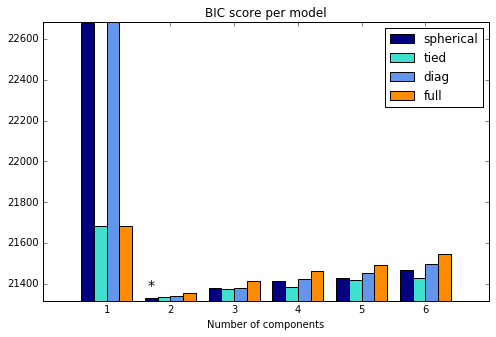

In [324]:
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []

# Plot the BIC scores
_,spl = plt.subplots(nrows=1, ncols=1, figsize=[8, 5])
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)



Now plot the winner

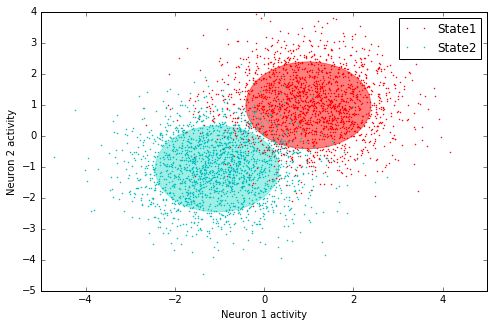

In [325]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8, 5])
ax.plot(raw_activity[0,gt_sts==0],raw_activity[1,gt_sts==0],'.r',label='State1',markerSize=2)
ax.plot(raw_activity[0,gt_sts==1],raw_activity[1,gt_sts==1],'.c',label='State2',markerSize=2)
ax.set_xlabel('Neuron 1 activity')
ax.set_ylabel('Neuron 2 activity')
ax.legend()
make_ellipses(best_gmm,ax)

and looser

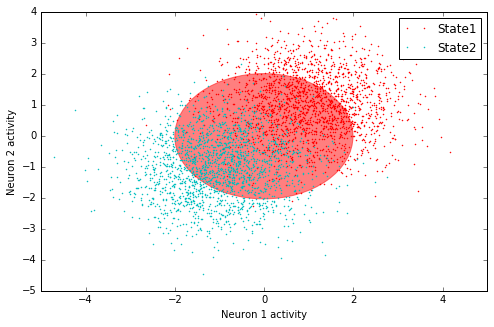

In [326]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8, 5])
ax.plot(raw_activity[0,gt_sts==0],raw_activity[1,gt_sts==0],'.r',label='State1',markerSize=2)
ax.plot(raw_activity[0,gt_sts==1],raw_activity[1,gt_sts==1],'.c',label='State2',markerSize=2)
ax.set_xlabel('Neuron 1 activity')
ax.set_ylabel('Neuron 2 activity')
ax.legend()
make_ellipses(worst_gmm,ax)

2.47544407509
22.2172070384


/home/manuel/.local/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/manuel/.local/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


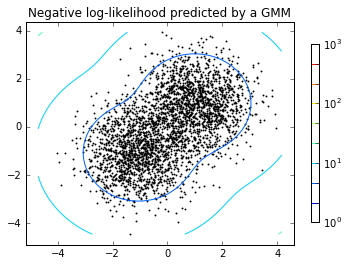

In [327]:
# display predicted scores by the model as a contour plot
x = np.linspace(np.min(raw_activity[0,:]), np.max(raw_activity[0,:]),50)
y = np.linspace(np.min(raw_activity[1,:]), np.max(raw_activity[1,:]),50)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

Z = -best_gmm.score_samples(XX)
Z = Z.reshape(X.shape)
print(np.min(Z))
print(np.max(Z))

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[0, :], X_train[1, :], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()


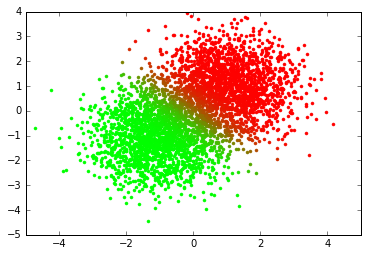

In [328]:
Z = best_gmm.predict_proba(raw_activity.T)
Z /= np.max(Z)

plt.figure()
for ind_p in range(raw_activity.shape[1]):
    plt.plot(raw_activity[0,ind_p],raw_activity[1,ind_p],'.',color=[1-Z[ind_p,1], 1-Z[ind_p,0], 0])
    

/home/manuel/.local/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/manuel/.local/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


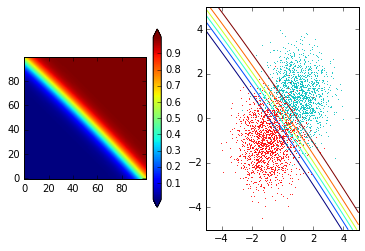

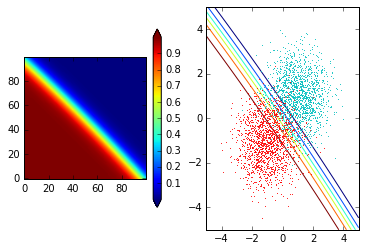

In [334]:
# display predicted scores by the model as a contour plot
#x = np.linspace(np.min(raw_activity[0,:]), np.max(raw_activity[0,:]),50)
#y = np.linspace(np.min(raw_activity[1,:]), np.max(raw_activity[1,:]),50)
limit = 5
x = np.linspace(-limit,limit,100)
y = np.linspace(-limit,limit,100)

X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

Z = best_gmm.predict_proba(XX)

for ind_z in range(best_gmm.n_components):
    Z_temp = Z[:,ind_z]
    Z_temp = Z_temp.reshape(X.shape)
    #Z_temp /= np.sum(Z_temp.flatten())
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(Z_temp,origin='lower')
    CB = plt.colorbar(shrink=0.8, extend='both')
    plt.subplot(1,2,2)
    plt.plot(X_train[0, y_train==0], X_train[1, y_train==0], '.c',markerSize=1)
    plt.plot(X_train[0, y_train==1], X_train[1, y_train==1], '.r',markerSize=1)
    CS = plt.contour(X, Y, Z_temp)#, norm=LogNorm(vmin=0.001, vmax=1000000.0),levels=np.logspace(0, 3, 100))
    plt.axis('equal')
    plt.axis('tight')
    




plt.show()
